# From Logistic Regression to Neural Networks

**This notebook follows ideas from Lecture 2 + Slides**

In this notebook, we'll build intuition by starting simple and scaling up:
1. **Linear Decision Boundaries** — The simplest classifier
2. **The Perceptron** — Hard thresholds and error-driven learning
3. **Logistic Regression** — Smoothing things out with probabilities
4. **The Limitation** — When lines aren't enough (XOR problem)
5. **Neural Networks** — Stacking layers to learn curves
6. **Scaling Up** — From 2D toy data to MNIST

---

In [48]:
# Core imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import display, HTML

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Nice plotting defaults
plt.rcParams['figure.figsize'] = (12, 8) # Increased figure size
plt.rcParams['font.size'] = 14 # Slightly larger font

# Transparent background
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['savefig.facecolor'] = 'none' # For saved figures

# Colors for dark background visibility
plt.rcParams['text.color'] = 'lightgray' # Changed text color to lightgray
plt.rcParams['axes.labelcolor'] = 'lightgray'
plt.rcParams['xtick.color'] = 'lightgray'
plt.rcParams['ytick.color'] = 'lightgray'
plt.rcParams['axes.edgecolor'] = 'lightgray'
plt.rcParams['grid.color'] = 'darkgrey'

print("Matplotlib configured for transparent plot backgrounds and dark mode visibility. 🎨")


print("PyTorch version:", torch.__version__)
print("Ready to go! 🚀")

Matplotlib configured for transparent plot backgrounds and dark mode visibility. 🎨
PyTorch version: 2.9.0+cpu
Ready to go! 🚀


---
## Part 1: A Motivating Problem

Let's create a simple 2D classification problem: predict whether a student passes or fails based on:
- $x_1$ = hours talking to Ren
- $x_2$ = hours slept

This gives us data we can easily visualize.

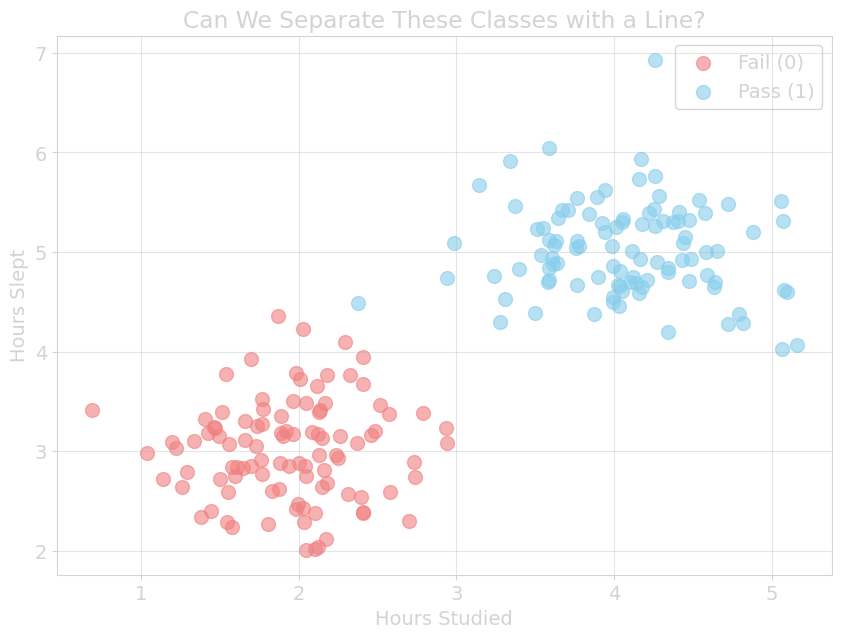

In [49]:
def generate_linearly_separable_data(n_samples=100, noise=0.3):
    """
    Generate 2D data that's (mostly) linearly separable.
    Class 0: Low study + low sleep → Fail
    Class 1: High study + high sleep → Pass
    """
    # Class 0: centered at (2, 3)
    class0 = np.random.randn(n_samples // 2, 2) * noise + np.array([2, 3])

    # Class 1: centered at (4, 5)
    class1 = np.random.randn(n_samples // 2, 2) * noise + np.array([4, 5])

    X = np.vstack([class0, class1])
    y = np.array([0] * (n_samples // 2) + [1] * (n_samples // 2))

    # Shuffle
    idx = np.random.permutation(n_samples)
    return X[idx], y[idx]

# Generate our dataset
X_train, y_train = generate_linearly_separable_data(200, noise=0.5)

# Visualize
plt.figure(figsize=(10, 7)) # Adjust figsize for this specific plot
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
            c='lightcoral', label='Fail (0)', s=100, alpha=0.6) # Softer color, larger, transparent, no edge
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
            c='skyblue', label='Pass (1)', s=100, alpha=0.6) # Softer color, larger, transparent, no edge
plt.xlabel('Hours Talking to Ren')
plt.ylabel('Hours Slept')
plt.title('Can We Separate These Classes with a Line?')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---
## Part 2: The Linear Decision Boundary

The simplest approach: find a line that separates the two classes.

**The Math:**
$$z = w_1 x_1 + w_2 x_2 + b = \mathbf{w}^\top \mathbf{x} + b$$

- Points where $z = 0$ form the **decision boundary**
- $z > 0$ → predict class 1
- $z < 0$ → predict class 0

The weights $\mathbf{w}$ define the orientation of the line, and $b$ shifts it.

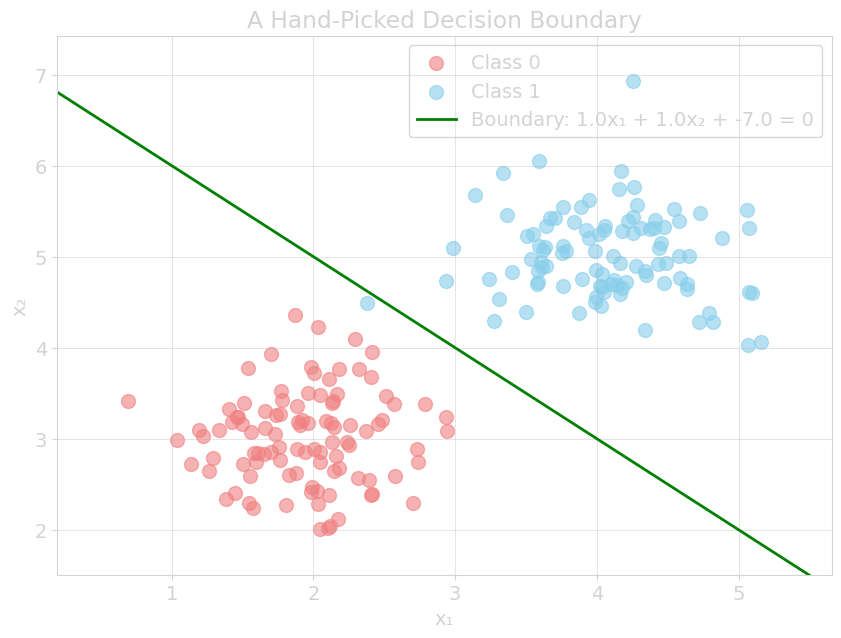

In [50]:
def plot_decision_boundary(X, y, w1, w2, b, title="Decision Boundary"):
    """
    Plot data points and the linear decision boundary w1*x1 + w2*x2 + b = 0
    """
    plt.figure(figsize=(10, 7)) # Adjust figsize for this specific plot

    # Plot points
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='lightcoral', label='Class 0', s=100, alpha=0.6) # Softer color, larger, transparent, no edge
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='skyblue', label='Class 1', s=100, alpha=0.6) # Softer color, larger, transparent, no edge

    # Plot decision boundary: w1*x1 + w2*x2 + b = 0 → x2 = -(w1*x1 + b) / w2
    x1_range = np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 100)
    if abs(w2) > 1e-6:  # Avoid division by zero
        x2_boundary = -(w1 * x1_range + b) / w2
        plt.plot(x1_range, x2_boundary, 'g-', linewidth=2, label=f'Boundary: {w1:.1f}x₁ + {w2:.1f}x₂ + {b:.1f} = 0')

    plt.xlabel('x₁')
    plt.ylabel('x₂')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
    plt.ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
    plt.show()

# Let's try a manual boundary
plot_decision_boundary(X_train, y_train, w1=1, w2=1, b=-7,
                       title="A Hand-Picked Decision Boundary")

**Question:** How do we find the *best* weights automatically?

---
## Part 3: The Perceptron

The **perceptron** (Rosenblatt, 1958) is the simplest learning algorithm for classification.

**The Model:**
$$\hat{y} = \begin{cases} 1 & \text{if } z = \mathbf{w}^\top \mathbf{x} + b \geq 0 \\ 0 & \text{if } z < 0 \end{cases}$$

**The Learning Rule:** Update weights only when we make a mistake:
```
If prediction is wrong:
    w ← w + η(y - ŷ)x
    b ← b + η(y - ŷ)
```

Where $\eta$ is the learning rate.

In [51]:
class Perceptron:
    """
    A simple perceptron classifier.
    """
    def __init__(self, input_dim, lr=0.1):
        self.w = np.zeros(input_dim)
        self.b = 0.0
        self.lr = lr
        self.history = []  # Track weights over time for visualization

    def predict(self, X):
        """Hard threshold prediction."""
        z = X @ self.w + self.b
        return (z >= 0).astype(int)

    def train_step(self, x, y):
        """One update step on a single example."""
        y_pred = int((x @ self.w + self.b) >= 0)

        if y_pred != y:  # Misclassified!
            error = y - y_pred  # Will be +1 or -1
            self.w = self.w + self.lr * error * x
            self.b = self.b + self.lr * error
            return True  # Made an update
        return False  # No update needed

    def fit(self, X, y, epochs=100):
        """Train on the dataset for multiple epochs."""
        self.history = [(self.w.copy(), self.b)]

        for epoch in range(epochs):
            errors = 0
            for i in range(len(X)):
                if self.train_step(X[i], y[i]):
                    errors += 1
                    self.history.append((self.w.copy(), self.b))

            if errors == 0:
                print(f"Converged at epoch {epoch + 1}!")
                break
        else:
            print(f"Did not converge after {epochs} epochs.")

        return self

# Train the perceptron
perceptron = Perceptron(input_dim=2, lr=0.1)
perceptron.fit(X_train, y_train, epochs=100)

# Show final accuracy
preds = perceptron.predict(X_train)
accuracy = (preds == y_train).mean()
print(f"Final accuracy: {accuracy:.1%}")
print(f"Final weights: w = [{perceptron.w[0]:.3f}, {perceptron.w[1]:.3f}], b = {perceptron.b:.3f}")

Converged at epoch 21!
Final accuracy: 100.0%
Final weights: w = [1.190, 0.650], b = -5.600


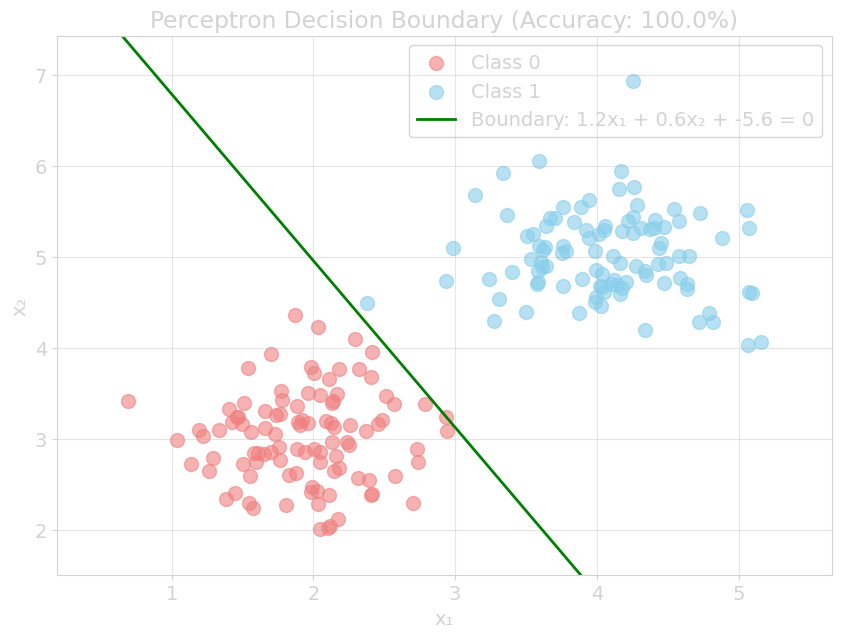

In [52]:
# Visualize the learned boundary
plot_decision_boundary(X_train, y_train,
                       perceptron.w[0], perceptron.w[1], perceptron.b,
                       title=f"Perceptron Decision Boundary (Accuracy: {accuracy:.1%})")

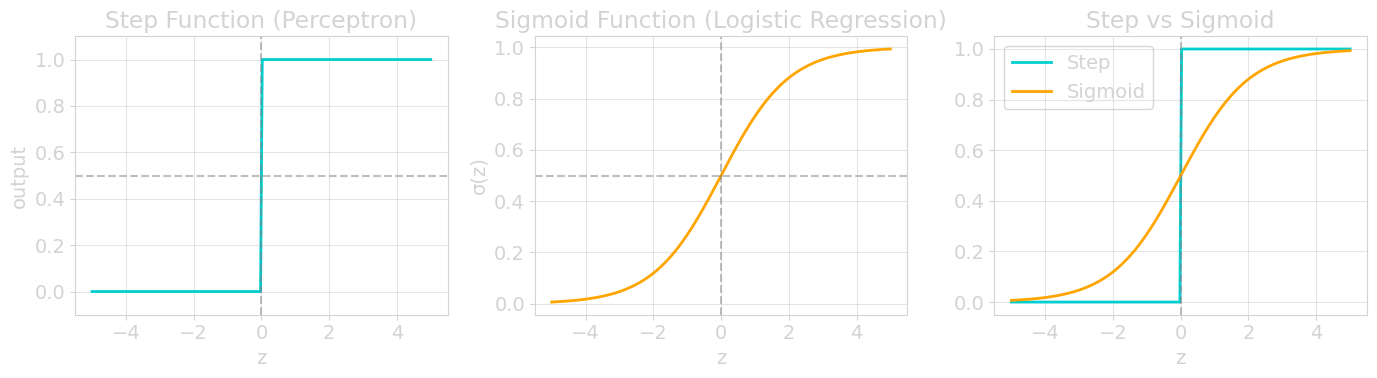

Key insight: The sigmoid is a 'smoothed' version of the step function.
This smoothness enables gradient-based learning!


In [53]:
# Visualize the step function vs smooth alternatives
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

z = np.linspace(-5, 5, 200)

# Step function (perceptron)
axes[0].plot(z, (z >= 0).astype(float), 'darkturquoise', linewidth=2) # Nicer color
axes[0].axvline(0, color='grey', linestyle='--', alpha=0.5)
axes[0].axhline(0.5, color='grey', linestyle='--', alpha=0.5)
axes[0].set_title('Step Function (Perceptron)')
axes[0].set_xlabel('z')
axes[0].set_ylabel('output')
axes[0].grid(True, alpha=0.3, color='darkgrey') # Softer grid
axes[0].set_ylim(-0.1, 1.1)

# Sigmoid (logistic regression)
sigmoid = 1 / (1 + np.exp(-z))
axes[1].plot(z, sigmoid, 'orange', linewidth=2) # Nicer color
axes[1].axvline(0, color='grey', linestyle='--', alpha=0.5)
axes[1].axhline(0.5, color='grey', linestyle='--', alpha=0.5)
axes[1].set_title('Sigmoid Function (Logistic Regression)')
axes[1].set_xlabel('z')
axes[1].set_ylabel('σ(z)')
axes[1].grid(True, alpha=0.3, color='darkgrey') # Softer grid

# Overlay comparison
axes[2].plot(z, (z >= 0).astype(float), 'darkturquoise', linewidth=2, label='Step') # Nicer color
axes[2].plot(z, sigmoid, 'orange', linewidth=2, label='Sigmoid') # Nicer color
axes[2].axvline(0, color='grey', linestyle='--', alpha=0.5)
axes[2].set_title('Step vs Sigmoid')
axes[2].set_xlabel('z')
axes[2].legend()
axes[2].grid(True, alpha=0.3, color='darkgrey') # Softer grid

plt.tight_layout()
plt.show()

print("Key insight: The sigmoid is a 'smoothed' version of the step function.")
print("This smoothness enables gradient-based learning!")

### Perceptron Limitations

1. **No probability output** — just 0 or 1, no confidence
2. **No smooth gradient** — can't use gradient descent
3. **Only converges if data is linearly separable** — oscillates forever otherwise

---
## Part 4: Logistic Regression

**The fix:** Replace the step function with the **sigmoid** function:

$$\hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}}$$

Now $\hat{y} \in (0, 1)$ — we can interpret it as a **probability**!

**Loss function:** Binary Cross-Entropy
$$\mathcal{L} = -[y \log(\hat{y}) + (1-y)\log(1-\hat{y})]$$

**Gradient:**
$$\frac{\partial \mathcal{L}}{\partial w_j} = (\hat{y} - y) x_j$$

This is smooth → we can use gradient descent!

In [54]:
# Logistic Regression from scratch (NumPy)
class LogisticRegressionNumpy:
    """
    Logistic regression implemented with NumPy.
    """
    def __init__(self, input_dim, lr=0.1):
        self.w = np.zeros(input_dim)
        self.b = 0.0
        self.lr = lr
        self.loss_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

    def predict_proba(self, X):
        """Return probabilities."""
        z = X @ self.w + self.b
        return self.sigmoid(z)

    def predict(self, X):
        """Return class predictions."""
        return (self.predict_proba(X) >= 0.5).astype(int)

    def compute_loss(self, X, y):
        """Binary cross-entropy loss."""
        y_pred = self.predict_proba(X)
        y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)  # Avoid log(0)
        return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

    def fit(self, X, y, epochs=100):
        """Train using gradient descent."""
        n = len(X)

        for epoch in range(epochs):
            # Forward pass
            y_pred = self.predict_proba(X)

            # Compute gradients
            error = y_pred - y  # Shape: (n,)
            dw = (X.T @ error) / n  # Shape: (input_dim,)
            db = np.mean(error)

            # Update weights
            self.w -= self.lr * dw
            self.b -= self.lr * db

            # Track loss
            loss = self.compute_loss(X, y)
            self.loss_history.append(loss)

            if (epoch + 1) % 20 == 0:
                acc = (self.predict(X) == y).mean()
                print(f"Epoch {epoch + 1}: Loss = {loss:.4f}, Accuracy = {acc:.1%}")

        return self

# Train logistic regression
logreg_np = LogisticRegressionNumpy(input_dim=2, lr=1.0)
logreg_np.fit(X_train, y_train, epochs=100)

Epoch 20: Loss = 1.4663, Accuracy = 51.0%
Epoch 40: Loss = 0.3571, Accuracy = 80.5%
Epoch 60: Loss = 0.7767, Accuracy = 64.5%
Epoch 80: Loss = 0.1675, Accuracy = 94.5%
Epoch 100: Loss = 0.1228, Accuracy = 97.0%


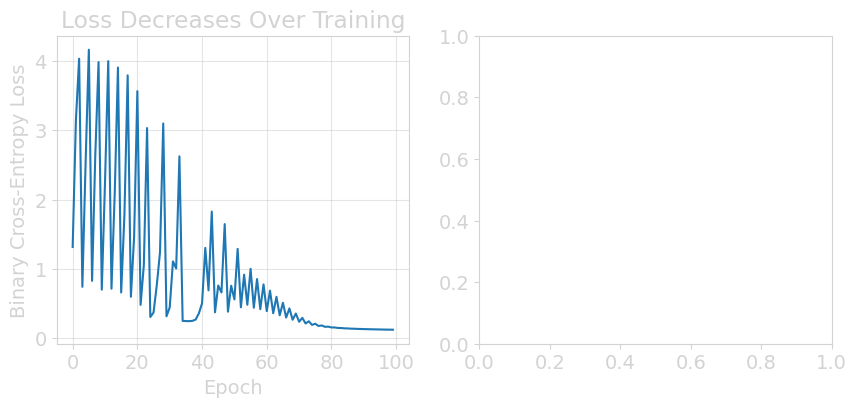

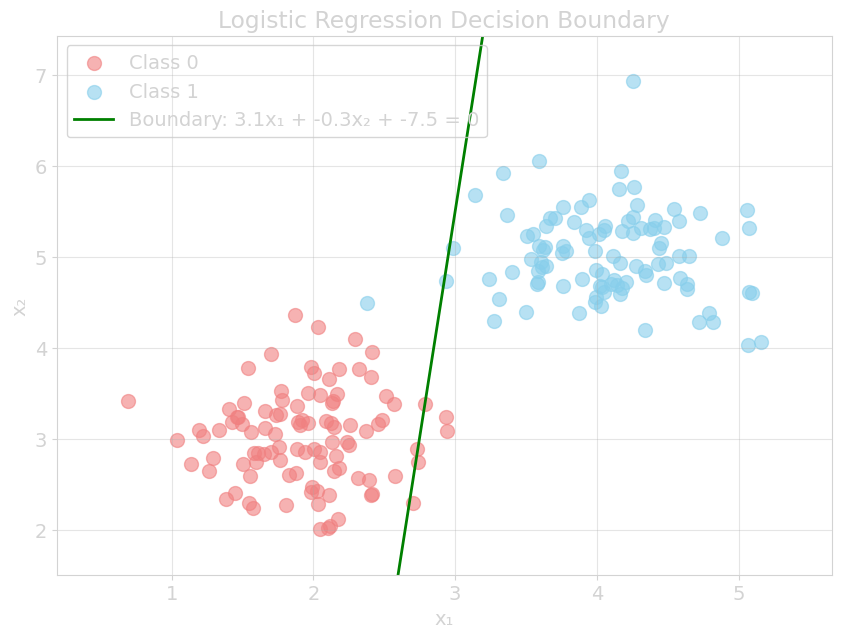

<Figure size 1200x800 with 0 Axes>

In [55]:
# Plot the loss curve
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(logreg_np.loss_history)
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Loss Decreases Over Training')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plot_decision_boundary(X_train, y_train,
                       logreg_np.w[0], logreg_np.w[1], logreg_np.b,
                       title="Logistic Regression Decision Boundary")

plt.tight_layout()
plt.show()

---
## Part 5: Logistic Regression in PyTorch

Now let's see how PyTorch makes this easier!

In [56]:
# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Shape: (n, 1)

print(f"X shape: {X_tensor.shape}")
print(f"y shape: {y_tensor.shape}")

X shape: torch.Size([200, 2])
y shape: torch.Size([200, 1])


In [57]:
# Method 1: Using nn.Sequential (simplest)
model_sequential = nn.Sequential(
    nn.Linear(2, 1),   # 2 inputs → 1 output
    nn.Sigmoid()       # Squash to (0, 1)
)

print("Sequential model:")
print(model_sequential)

Sequential model:
Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)


In [58]:
# Method 2: Using a class (more flexible)
class LogisticRegressionTorch(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        z = self.linear(x)         # z = Wx + b
        return torch.sigmoid(z)    # σ(z)

model = LogisticRegressionTorch(input_dim=2)

# Inspect the parameters
print("Model parameters:")
for name, param in model.named_parameters():
    print(f"  {name}: shape {param.shape}")

Model parameters:
  linear.weight: shape torch.Size([1, 2])
  linear.bias: shape torch.Size([1])


In [59]:
# Training loop in PyTorch
model = LogisticRegressionTorch(input_dim=2)

criterion = nn.BCELoss()  # Binary Cross-Entropy
optimizer = optim.SGD(model.parameters(), lr=1.0)

losses = []
for epoch in range(100):
    # Forward pass
    y_pred = model(X_tensor)
    loss = criterion(y_pred, y_tensor)

    # Backward pass
    optimizer.zero_grad()  # Clear old gradients
    loss.backward()        # Compute new gradients
    optimizer.step()       # Update weights

    losses.append(loss.item())

    if (epoch + 1) % 20 == 0:
        with torch.no_grad():
            acc = ((y_pred >= 0.5).float() == y_tensor).float().mean()
        print(f"Epoch {epoch + 1}: Loss = {loss.item():.4f}, Accuracy = {acc:.1%}")

print("\n✅ Training complete!")

Epoch 20: Loss = 1.9613, Accuracy = 50.0%
Epoch 40: Loss = 0.6028, Accuracy = 68.0%
Epoch 60: Loss = 0.8320, Accuracy = 63.5%
Epoch 80: Loss = 0.1933, Accuracy = 92.5%
Epoch 100: Loss = 0.1272, Accuracy = 96.5%

✅ Training complete!


Learned weights: w = [3.115, -0.385], b = -7.437


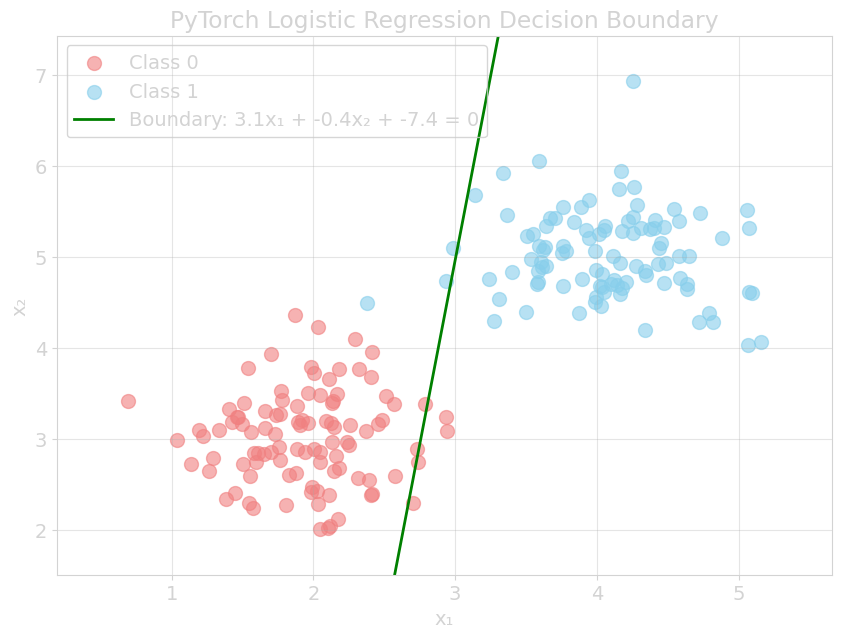

In [60]:
# Extract learned weights and visualize
w = model.linear.weight.detach().numpy().flatten()
b = model.linear.bias.detach().numpy()[0]

print(f"Learned weights: w = [{w[0]:.3f}, {w[1]:.3f}], b = {b:.3f}")

plot_decision_boundary(X_train, y_train, w[0], w[1], b,
                       title="PyTorch Logistic Regression Decision Boundary")

### 🔑 Key PyTorch Pattern

```python
# The fundamental training loop:
optimizer.zero_grad()   # 1. Clear old gradients
y_pred = model(x)       # 2. Forward pass
loss = criterion(y_pred, y)  # 3. Compute loss
loss.backward()         # 4. Backpropagation
optimizer.step()        # 5. Update weights
```

---
## Part 6: The Limitation — Non-Linearly Separable Data

What happens when data **cannot** be separated by a line?

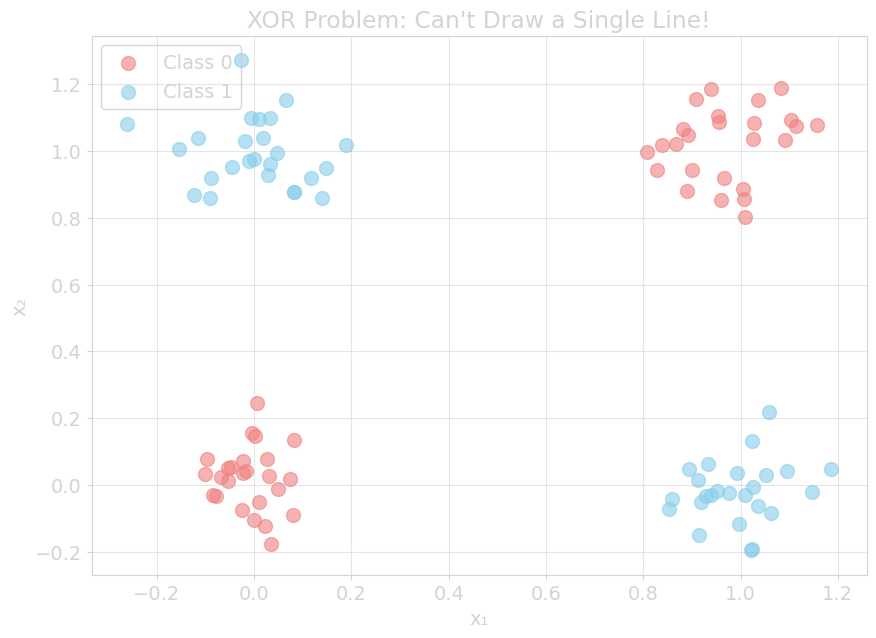

☠️ No single line can separate the red and blue points!


In [61]:
# The XOR problem: Neither class can be separated by a single line
X_xor = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])
y_xor = np.array([0, 1, 1, 0])  # XOR: same inputs → 0, different → 1

# Add some noise for visualization
np.random.seed(42)
X_xor_noisy = np.vstack([
    X_xor + np.random.randn(4, 2) * 0.1 for _ in range(25)
])
y_xor_noisy = np.tile(y_xor, 25)

plt.figure(figsize=(10, 7)) # Adjust figsize for this specific plot
plt.scatter(X_xor_noisy[y_xor_noisy == 0, 0], X_xor_noisy[y_xor_noisy == 0, 1],
            c='lightcoral', label='Class 0', s=100, alpha=0.6) # Softer color, larger, transparent, no edge
plt.scatter(X_xor_noisy[y_xor_noisy == 1, 0], X_xor_noisy[y_xor_noisy == 1, 1],
            c='skyblue', label='Class 1', s=100, alpha=0.6) # Softer color, larger, transparent, no edge
plt.title('XOR Problem: Can\'t Draw a Single Line!')
plt.xlabel('x₁')
plt.ylabel('x₂')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("☠️ No single line can separate the red and blue points!")

In [62]:
# Try logistic regression on XOR
X_xor_tensor = torch.tensor(X_xor_noisy, dtype=torch.float32)
y_xor_tensor = torch.tensor(y_xor_noisy, dtype=torch.float32).unsqueeze(1)

model_xor_linear = LogisticRegressionTorch(input_dim=2)
criterion = nn.BCELoss()
optimizer = optim.SGD(model_xor_linear.parameters(), lr=1.0)

for epoch in range(200):
    y_pred = model_xor_linear(X_xor_tensor)
    loss = criterion(y_pred, y_xor_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

with torch.no_grad():
    acc = ((model_xor_linear(X_xor_tensor) >= 0.5).float() == y_xor_tensor).float().mean()

print(f"Logistic Regression on XOR: Accuracy = {acc:.1%}")
print("(Random guessing would be 50% — we can't do better with a line!)")

Logistic Regression on XOR: Accuracy = 51.0%
(Random guessing would be 50% — we can't do better with a line!)


---
## Part 7: Neural Networks — Adding Hidden Layers

**The Key Insight:** One neuron = one line. What if we combine multiple?

**Two-Stage Transformation:**

$$\mathbf{h} = \sigma(W^{(1)}\mathbf{x} + \mathbf{b}^{(1)})$$

$$\hat{y} = \sigma(\mathbf{w}^{(2)\top}\mathbf{h} + b^{(2)})$$

- **First layer:** Learn new features $\mathbf{h}$
- **Second layer:** Logistic regression on those features

Each hidden neuron is like its own logistic regression!

In [63]:
class SimpleNeuralNetwork(nn.Module):
    """
    A neural network with one hidden layer.
    """
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super().__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)  # First layer
        self.output = nn.Linear(hidden_dim, output_dim)  # Second layer

    def forward(self, x):
        # Hidden layer with activation
        h = torch.relu(self.hidden(x))  # ReLU is common for hidden layers
        # Output layer
        out = torch.sigmoid(self.output(h))
        return out

# Create a network with 4 hidden neurons
model_nn = SimpleNeuralNetwork(input_dim=2, hidden_dim=4)

print("Neural Network Architecture:")
print(model_nn)
print("\nParameter count:")
total_params = sum(p.numel() for p in model_nn.parameters())
print(f"  Total: {total_params} parameters")

Neural Network Architecture:
SimpleNeuralNetwork(
  (hidden): Linear(in_features=2, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=1, bias=True)
)

Parameter count:
  Total: 17 parameters


In [64]:
# Train the neural network on XOR
model_nn = SimpleNeuralNetwork(input_dim=2, hidden_dim=8)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=0.1)  # Adam often works better

losses = []
for epoch in range(500):
    y_pred = model_nn(X_xor_tensor)
    loss = criterion(y_pred, y_xor_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if (epoch + 1) % 100 == 0:
        with torch.no_grad():
            acc = ((model_nn(X_xor_tensor) >= 0.5).float() == y_xor_tensor).float().mean()
        print(f"Epoch {epoch + 1}: Loss = {loss.item():.4f}, Accuracy = {acc:.1%}")

print("\n✅ Neural network can solve XOR!")

Epoch 100: Loss = 0.0027, Accuracy = 100.0%
Epoch 200: Loss = 0.0011, Accuracy = 100.0%
Epoch 300: Loss = 0.0007, Accuracy = 100.0%
Epoch 400: Loss = 0.0004, Accuracy = 100.0%
Epoch 500: Loss = 0.0003, Accuracy = 100.0%

✅ Neural network can solve XOR!


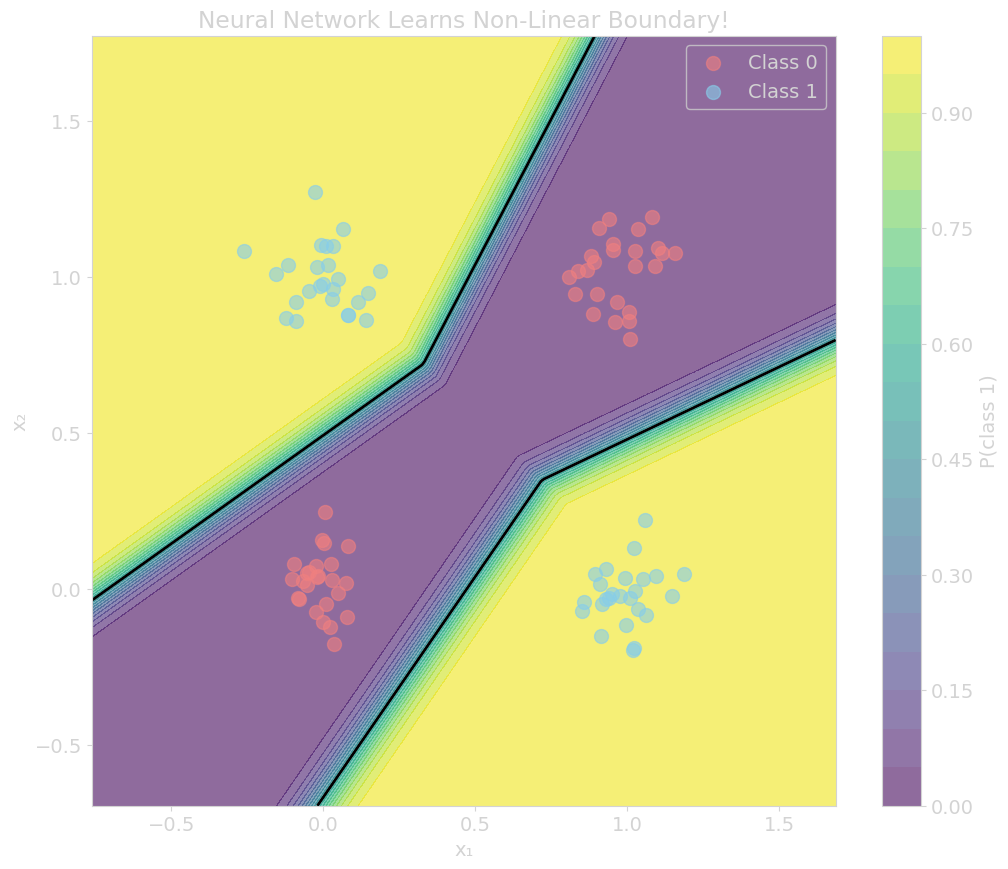

In [65]:
# Visualize the non-linear decision boundary
def plot_decision_regions(model, X, y, title="Decision Regions"):
    """
    Plot the decision regions learned by a model.
    """
    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    # Get predictions for the mesh
    mesh_input = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        Z = model(mesh_input).numpy().reshape(xx.shape)

    # Plot
    plt.figure(figsize=(12, 10)) # Increased figsize
    plt.contourf(xx, yy, Z, levels=20, cmap='viridis', alpha=0.6) # Changed cmap for decision regions
    plt.colorbar(label='P(class 1)')
    plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='lightcoral', label='Class 0',
                s=100, alpha=0.6) # Softer color, larger, transparent, no edge
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='skyblue', label='Class 1',
                s=100, alpha=0.6) # Softer color, larger, transparent, no edge

    plt.title(title)
    plt.xlabel('x₁')
    plt.ylabel('x₂')
    plt.legend()
    plt.show()

plot_decision_regions(model_nn, X_xor_noisy, y_xor_noisy,
                      title="Neural Network Learns Non-Linear Boundary!")

### Why Do Activations Matter?

Without activation functions, stacking layers collapses to a single linear transformation:

$$W^{(2)}(W^{(1)}\mathbf{x} + \mathbf{b}^{(1)}) + \mathbf{b}^{(2)} = W'\mathbf{x} + \mathbf{b}'$$

**Activations break linearity** → the network can learn curves!

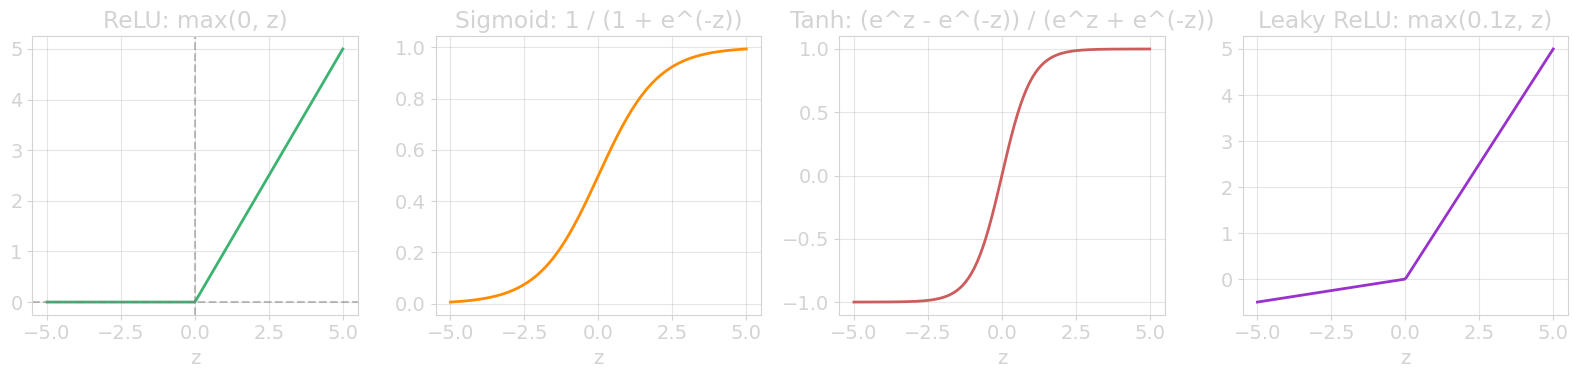

💡 In practice: ReLU for hidden layers, Sigmoid/Softmax for output.


In [66]:
# Compare activation functions
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

z = np.linspace(-5, 5, 200)

# ReLU
axes[0].plot(z, np.maximum(0, z), 'mediumseagreen', linewidth=2) # Nicer color
axes[0].set_title('ReLU: max(0, z)')
axes[0].set_xlabel('z')
axes[0].grid(True, alpha=0.3, color='darkgrey') # Softer grid
axes[0].axhline(0, color='grey', linestyle='--', alpha=0.5)
axes[0].axvline(0, color='grey', linestyle='--', alpha=0.5)

# Sigmoid
axes[1].plot(z, 1 / (1 + np.exp(-z)), 'darkorange', linewidth=2) # Nicer color
axes[1].set_title('Sigmoid: 1 / (1 + e^(-z))') # Corrected notation
axes[1].set_xlabel('z')
axes[1].grid(True, alpha=0.3, color='darkgrey') # Softer grid

# Tanh
axes[2].plot(z, np.tanh(z), 'indianred', linewidth=2) # Nicer color
axes[2].set_title('Tanh: (e^z - e^(-z)) / (e^z + e^(-z))') # Corrected notation
axes[2].set_xlabel('z')
axes[2].grid(True, alpha=0.3, color='darkgrey') # Softer grid

# Leaky ReLU
axes[3].plot(z, np.where(z > 0, z, 0.1 * z), 'darkorchid', linewidth=2) # Nicer color
axes[3].set_title('Leaky ReLU: max(0.1z, z)')
axes[3].set_xlabel('z')
axes[3].grid(True, alpha=0.3, color='darkgrey') # Softer grid

plt.tight_layout()
plt.show()

print("💡 In practice: ReLU for hidden layers, Sigmoid/Softmax for output.")

---
## Part 8: Scaling Up — MNIST

Let's apply what we learned to a real dataset: handwritten digit classification!

In [67]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")

Training samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])


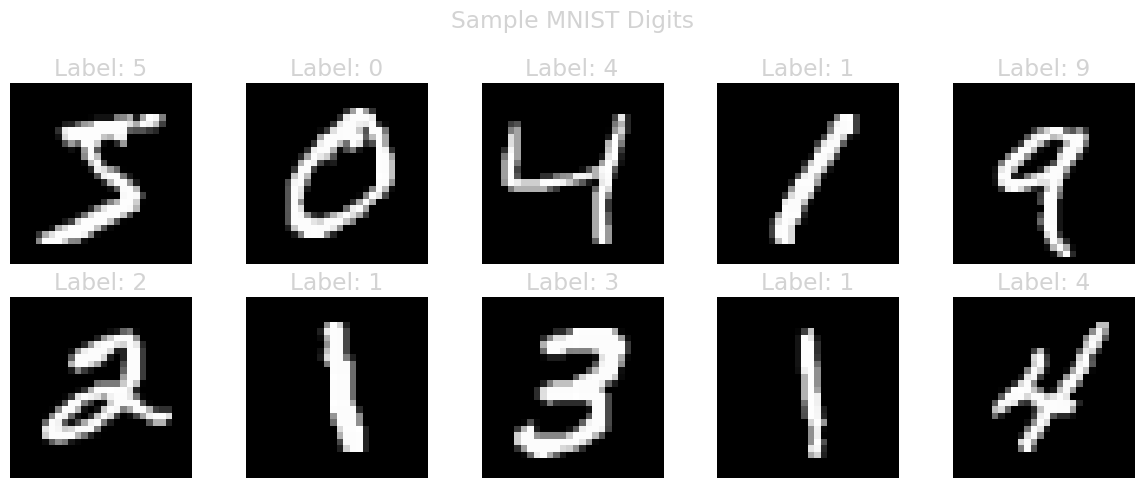

In [68]:
# Visualize some samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.suptitle('Sample MNIST Digits')
plt.tight_layout()
plt.show()

In [69]:
# Multi-class neural network for MNIST
class MNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()  # 28x28 → 784
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 output classes

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Raw logits (CrossEntropyLoss handles softmax)
        return x

model_mnist = MNISTNet()
print(model_mnist)
print(f"\nTotal parameters: {sum(p.numel() for p in model_mnist.parameters()):,}")

MNISTNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Total parameters: 109,386


In [70]:
# Training loop for MNIST
criterion = nn.CrossEntropyLoss()  # Combines softmax + negative log-likelihood
optimizer = optim.Adam(model_mnist.parameters(), lr=0.001)

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    return total_loss / total, correct / total

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            _, predicted = outputs.max(1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    return correct / total

# Train for a few epochs
print("Training MNIST classifier...\n")
for epoch in range(5):
    train_loss, train_acc = train_epoch(model_mnist, train_loader, criterion, optimizer)
    test_acc = evaluate(model_mnist, test_loader)
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, "
          f"Train Acc = {train_acc:.1%}, Test Acc = {test_acc:.1%}")

print("\n✅ Done! We built a working digit classifier.")

Training MNIST classifier...

Epoch 1: Train Loss = 0.2657, Train Acc = 92.1%, Test Acc = 95.6%
Epoch 2: Train Loss = 0.1106, Train Acc = 96.6%, Test Acc = 96.2%
Epoch 3: Train Loss = 0.0786, Train Acc = 97.5%, Test Acc = 97.4%
Epoch 4: Train Loss = 0.0599, Train Acc = 98.1%, Test Acc = 97.2%
Epoch 5: Train Loss = 0.0494, Train Acc = 98.4%, Test Acc = 97.5%

✅ Done! We built a working digit classifier.


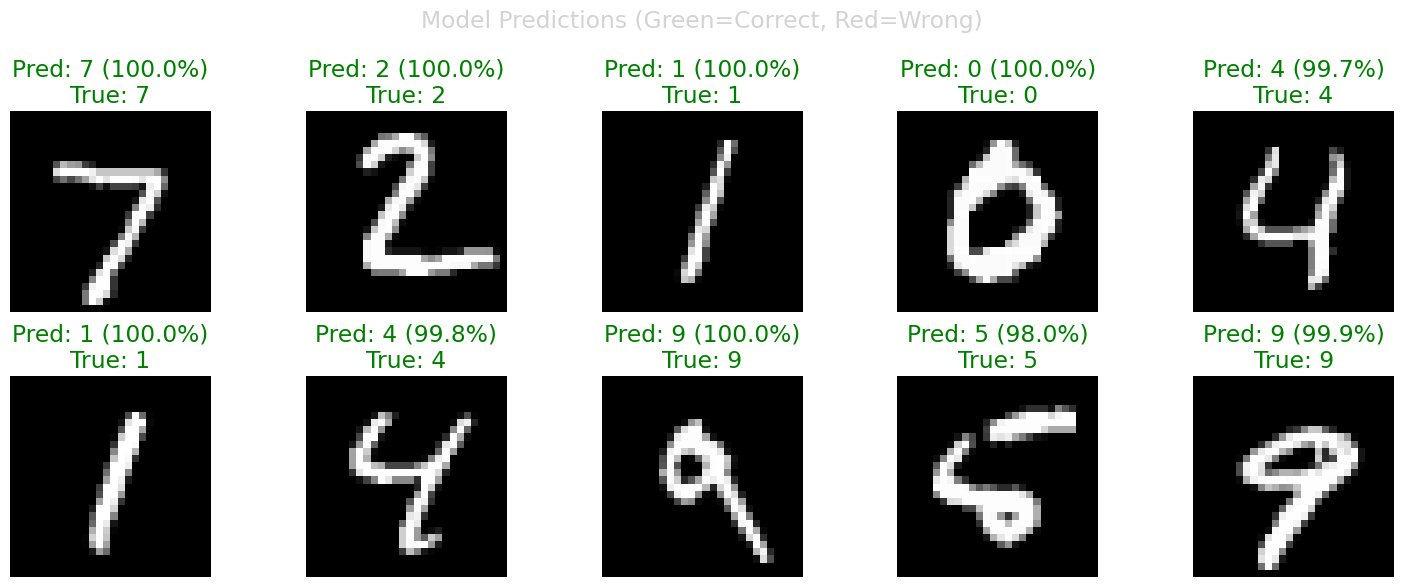

In [71]:
# Visualize some predictions
model_mnist.eval()
test_images, test_labels = next(iter(test_loader))

with torch.no_grad():
    outputs = model_mnist(test_images[:10])
    probs = torch.softmax(outputs, dim=1)
    preds = outputs.argmax(dim=1)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i].squeeze(), cmap='gray')
    color = 'green' if preds[i] == test_labels[i] else 'red'
    ax.set_title(f'Pred: {preds[i].item()} ({probs[i, preds[i]]:.1%})\nTrue: {test_labels[i].item()}',
                 color=color)
    ax.axis('off')
plt.suptitle('Model Predictions (Green=Correct, Red=Wrong)')
plt.tight_layout()
plt.show()

---
## Summary: The Progression

| Model | # Neurons | Activation | Can Learn |
|-------|-----------|------------|------------|
| **Perceptron** | 1 | Step | Linear boundaries |
| **Logistic Regression** | 1 | Sigmoid | Linear + probabilities |
| **Neural Network** | Many | ReLU/Sigmoid | Curves, complex boundaries |

### Key Takeaways

1. **Logistic regression = smoothed perceptron = one neuron**
2. **Hidden layers = learned feature transformations**
3. **Activations enable nonlinearity** (otherwise layers collapse)
4. **PyTorch pattern:** `zero_grad → forward → loss → backward → step`

### What's Next?

- **Convolutional Neural Networks (CNNs)** for image data
- **Regularization** (dropout, weight decay) to prevent overfitting
- **Batch normalization** for training stability
- **Different architectures** (ResNets, Transformers)

In [72]:
print("🎉 Congratulations! You've learned the foundations of neural networks!")
print("\nExercises to try:")
print("1. Add more hidden layers to the MNIST model. Does accuracy improve?")
print("2. Try different activation functions (Tanh, LeakyReLU).")
print("3. Experiment with learning rates and optimizers (SGD vs Adam).")
print("4. Can you beat 98% accuracy on MNIST?")

🎉 Congratulations! You've learned the foundations of neural networks!

Exercises to try:
1. Add more hidden layers to the MNIST model. Does accuracy improve?
2. Try different activation functions (Tanh, LeakyReLU).
3. Experiment with learning rates and optimizers (SGD vs Adam).
4. Can you beat 98% accuracy on MNIST?


## Visualizing Binary Cross-Entropy Loss

Binary Cross-Entropy (BCE) is the standard loss function for binary classification problems where the output is a probability between 0 and 1. It measures the performance of a classification model whose output is a probability value between 0 and 1.

**The Formula:**

For a single prediction $\hat{y}$ and true label $y$:

$$ \mathcal{L}(\hat{y}, y) = - [y \log(\hat{y}) + (1 - y) \log(1 - \hat{y})] $$

- If $y=1$, the loss is $-\log(\hat{y})$. This means as $\hat{y}$ approaches 1, the loss approaches 0. As $\hat{y}$ approaches 0, the loss approaches infinity.
- If $y=0$, the loss is $-\log(1 - \hat{y})$. This means as $\hat{y}$ approaches 0, the loss approaches 0. As $\hat{y}$ approaches 1, the loss approaches infinity.

Let's visualize this behavior.

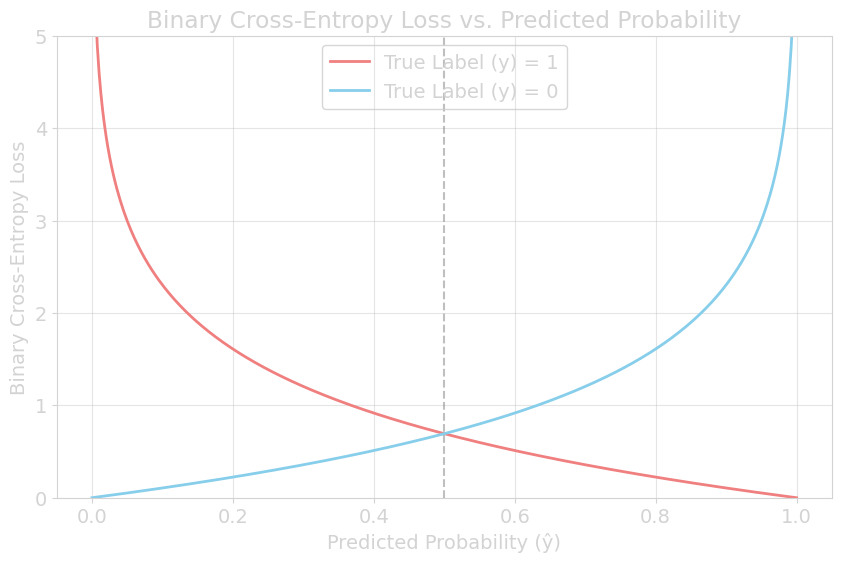

💡 Key takeaway: The loss is very high when the model is confident but wrong, and approaches zero when it's confident and correct.


In [73]:
import numpy as np
import matplotlib.pyplot as plt

def binary_cross_entropy_loss(y_true, y_pred):
    # Clip predictions to avoid log(0) which is undefined
    epsilon = 1e-10
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    if y_true == 1:
        return -np.log(y_pred)
    elif y_true == 0:
        return -np.log(1 - y_pred)
    else:
        raise ValueError("y_true must be 0 or 1")

# Generate a range of predicted probabilities
y_preds = np.linspace(0, 1, 400)

# Calculate loss for y_true = 1
loss_y_1 = [binary_cross_entropy_loss(1, yp) for yp in y_preds]

# Calculate loss for y_true = 0
loss_y_0 = [binary_cross_entropy_loss(0, yp) for yp in y_preds]

plt.figure(figsize=(10, 6))
plt.plot(y_preds, loss_y_1, label='True Label (y) = 1', color='lightcoral', linewidth=2)
plt.plot(y_preds, loss_y_0, label='True Label (y) = 0', color='skyblue', linewidth=2)

plt.xlabel('Predicted Probability (ŷ)')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Binary Cross-Entropy Loss vs. Predicted Probability')
plt.legend()
plt.grid(True, alpha=0.3, color='darkgrey')
plt.ylim(0, 5) # Limit y-axis for better visualization of typical losses
plt.axvline(0.5, color='gray', linestyle='--', alpha=0.5, label='Decision Threshold (0.5)')
plt.show()

print("💡 Key takeaway: The loss is very high when the model is confident but wrong, and approaches zero when it's confident and correct.")